In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
sepsis_df = pd.read_csv('sepsis_df.csv')

# create X and y for model
X = sepsis_df.drop(columns=['isSepsis'])
y = sepsis_df.isSepsis

# splitting data into Train, Val, & Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [3]:
# resampling using random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_train, y_train = ros.fit_resample(X_train,y_train)

In [5]:
from collections import Counter
Counter(y_train)

Counter({0: 10349, 1: 10349})

In [4]:
# scaling train, val, and test sets
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

### Logistic Regression (10-Fold CV)

In [12]:
logit = LogisticRegressionCV(Cs=1000, cv=10)
logit.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=1000, cv=10)

In [13]:
y_train_pred = logit.predict(X_train_scaled)
y_val_pred = logit.predict(X_val_scaled)

In [14]:
def scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=2)
    
    print(f'Accuracy score: {accuracy}')
    print(f'Precision score: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    print(f'F-beta (beta=2): {fbeta}')

In [15]:
scores(y_train, y_train_pred)

Accuracy score: 0.7707024833317229
Precision score: 0.8104843178543721
Recall: 0.7066383225432409
F1: 0.7550072269254595
F-beta (beta=2): 0.7252226343243618


In [16]:
scores(y_val, y_val_pred)

Accuracy score: 0.5379699248120301
Precision score: 0.05066250974279034
Recall: 0.8552631578947368
F1: 0.09565857247976454
F-beta (beta=2): 0.20478890989287968


In [29]:
y_pred = logit.predict(X)

In [30]:
scores(y, y_pred)

Accuracy score: 0.6813669454304795
Precision score: 0.06375293480223948
Recall: 0.7591397849462366
F1: 0.11762745751416194
F-beta (beta=2): 0.23861024739759365


### Precision and Recall Curves

In [17]:
plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)

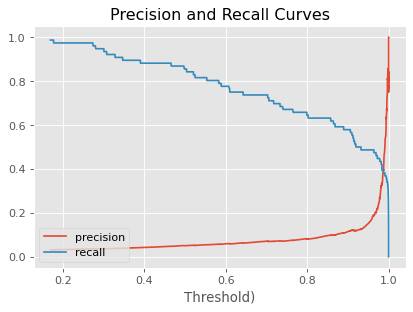

In [18]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, logit.predict_proba(X_val_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold)');
plt.title('Precision and Recall Curves');

In [31]:
def make_confusion_matrix_train(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_train_scaled)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y_train, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title('Logistic Regression confusion matrix');""

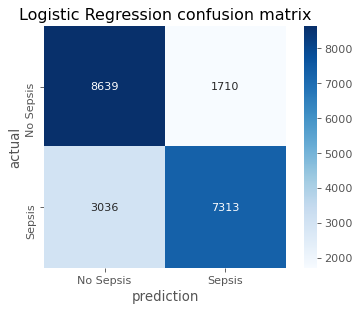

In [32]:
make_confusion_matrix_train(logit)

### Confusion Matrix

In [26]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val_scaled)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title('Logistic Regression confusion matrix');

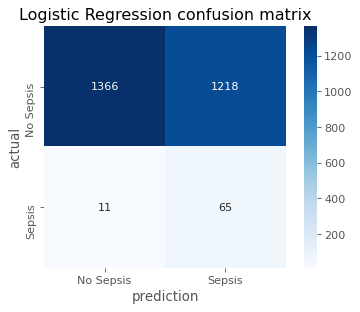

In [27]:
make_confusion_matrix(logit)

In [21]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(logit, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### ROC-AUC Curve

In [23]:
fpr, tpr, thresholds = roc_curve(y_val, logit.predict_proba(X_val_scaled)[:,1])

ROC AUC score =  0.8026417630764218


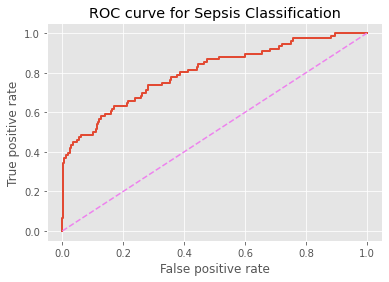

In [24]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Sepsis Classification');
print("ROC AUC score = ", roc_auc_score(y_val, logit.predict_proba(X_val_scaled)[:,1]))

### Log Loss

In [25]:
print("Log-loss on Logistic Regression Model: {:6.4f}".format(log_loss(y_val, logit.predict_proba(X_val_scaled))))

Log-loss on Logistic Regression Model: 1.0494
